In [2]:
# -----------------------------
# 1. Data Loading & Preprocessing
# -----------------------------
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load the dataset
df = pd.read_csv('Vaccine_dataset_AstraZeneca.csv')

# Preprocess function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['Cleaned_Tweet'] = df['Tweet'].apply(preprocess_text)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kusumranabhat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kusumranabhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kusumranabhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kusumranabhat/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# -----------------------------
# 2. Exploratory Data Analysis
# -----------------------------
print("Total number of tweets:", len(df))
print("Sentiment label counts:\n", df['Target'].value_counts())
print("\nPolarity statistics:\n", df['Polarity'].describe())  
print("\nSubjectivity statistics:\n", df['Subjectivity'].describe())


Total number of tweets: 1553
Sentiment label counts:
 Target
Positive    739
Neutral     677
Negative    136
Name: count, dtype: int64

Polarity statistics:
 count    1552.000000
mean        0.124392
std         0.227287
min        -0.750000
25%         0.000000
50%         0.000000
75%         0.250000
max         1.000000
Name: Polarity, dtype: float64

Subjectivity statistics:
 count    1552.000000
mean        0.351450
std         0.316576
min         0.000000
25%         0.000000
50%         0.366667
75%         0.550000
max         1.000000
Name: Subjectivity, dtype: float64


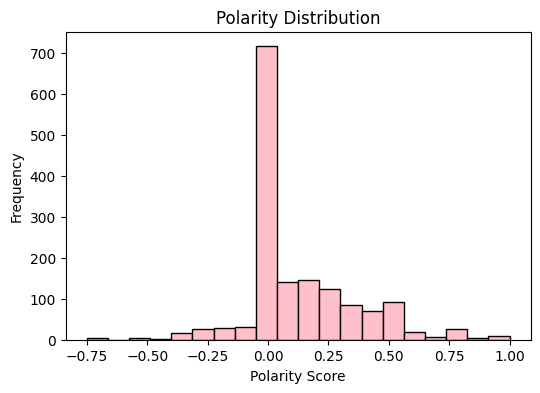

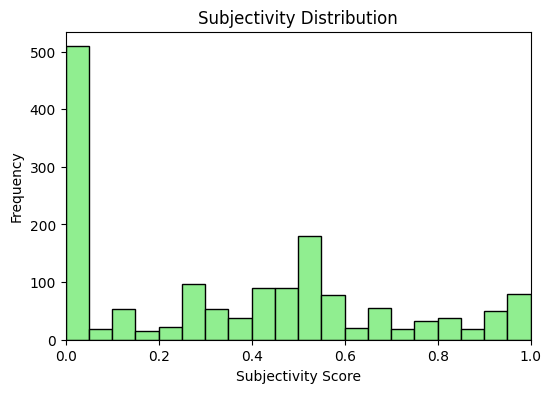

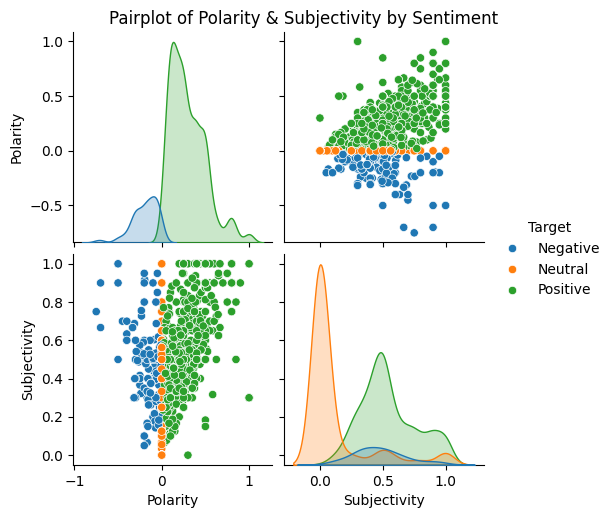

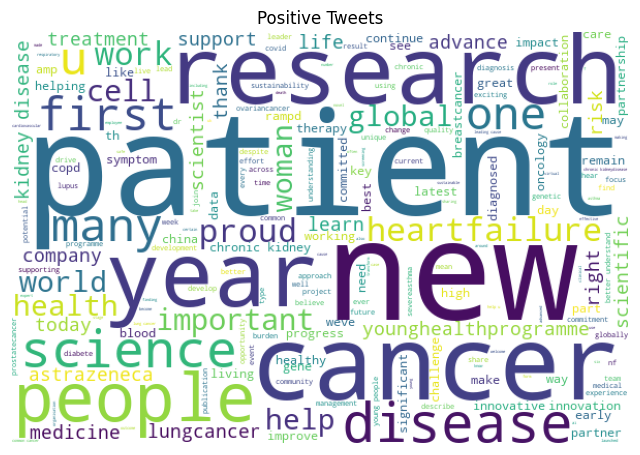

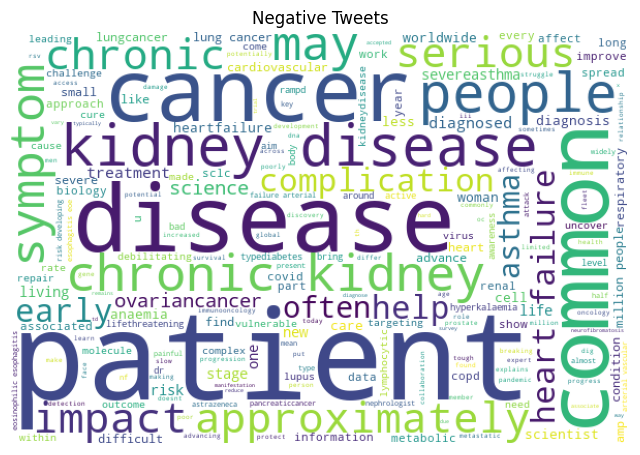

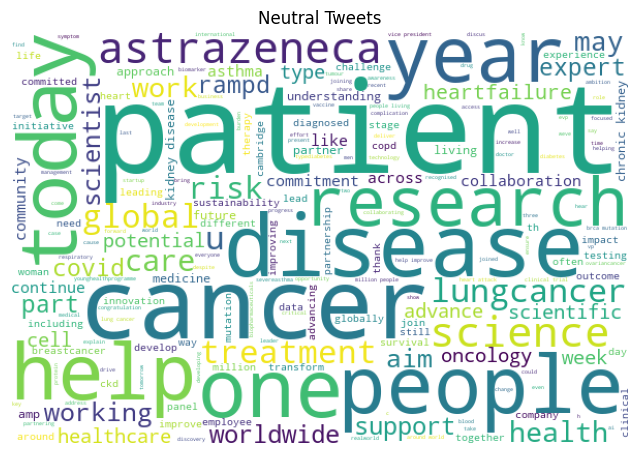

In [5]:
# -----------------------------
# 3. Visualizations
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Histograms
plt.figure(figsize=(6,4))
plt.hist(df['Polarity'], bins=20, edgecolor='black', color='pink')
plt.title('Polarity Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['Subjectivity'], bins=20, edgecolor='black', color='lightgreen')
plt.title('Subjectivity Distribution')
plt.xlabel('Subjectivity Score')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.show()

# Pairplot
sns.pairplot(df[['Polarity', 'Subjectivity', 'Target']], hue='Target')
plt.suptitle("Pairplot of Polarity & Subjectivity by Sentiment", y=1.02)
plt.show()

# WordClouds
positive_text = " ".join(df[df['Target'] == 'Positive']['Cleaned_Tweet'])
negative_text = " ".join(df[df['Target'] == 'Negative']['Cleaned_Tweet'])
neutral_text  = " ".join(df[df['Target'] == 'Neutral']['Cleaned_Tweet'])
wc = WordCloud(width=600, height=400, background_color='white', stopwords=stop_words)

plt.figure(figsize=(8,6)); plt.imshow(wc.generate(positive_text)); plt.axis('off'); plt.title('Positive Tweets'); plt.show()
plt.figure(figsize=(8,6)); plt.imshow(wc.generate(negative_text)); plt.axis('off'); plt.title('Negative Tweets'); plt.show()
plt.figure(figsize=(8,6)); plt.imshow(wc.generate(neutral_text)); plt.axis('off'); plt.title('Neutral Tweets'); plt.show()

In [8]:
# -----------------------------
# 4. Train-Test Split and Vectorization
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

df = df.dropna(subset=['Cleaned_Tweet', 'Target'])

X = df['Cleaned_Tweet']
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Number of features:", X_train_vec.shape[1])


Training set size: 1241
Test set size: 311
Number of features: 3246


In [9]:
# -----------------------------
# 5. Train and Evaluate MultinomialNB
# -----------------------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)

y_pred_nb = model_nb.predict(X_test_vec)

# Evaluation
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"\nMultinomialNB Accuracy: {acc_nb:.3f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb, labels=['Negative', 'Neutral', 'Positive']))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, digits=3))


MultinomialNB Accuracy: 0.688

Confusion Matrix:
[[  7  10  10]
 [  2  93  41]
 [  3  31 114]]

Classification Report:
              precision    recall  f1-score   support

    Negative      0.583     0.259     0.359        27
     Neutral      0.694     0.684     0.689       136
    Positive      0.691     0.770     0.728       148

    accuracy                          0.688       311
   macro avg      0.656     0.571     0.592       311
weighted avg      0.683     0.688     0.679       311

